# Predicting House Sale Prices

In this project we predict house sale prices using housing data for the city of Ames, Iowa, United States from 2006 to 2010. 

* <a target="_blank" href="https://www.kaggle.com/samaxtech/ames-housing-data#AmesHousing.tsv">Download Data</a>
* <a target="_blank" href="https://s3.amazonaws.com/dq-content/307/data_description.txt">Columns Explanation</a>

For this analysis we are going to define first a set of functions to be used in our data pipeline:
* **transform_features()** - Within this function we remove the non-numerical and other features that are not meaningful for our model. Besides that we remove all features that have more than 25% missing values. Finally we either delete the rows (for non continuous features) or replace the missing values for the mean()
* **select_features()** - After identifying the features which are highly correlated, we remove those of the pairs, which have less impact on the model. Within this funciton we also re-scale the features and remove those with very low variance.
* **train_and_test()** - Here we train and test our model with the remaining features. We perform the process by splitting the set in 50/50 (train/test) and also try different cross-validation combinations.

Results show that, for this dataset, increasing the number of datasets in the k-fold cross validation leads to always smaller RMSEs 

In [24]:
import pandas as pd
data = pd.read_csv('AmesHousing\AmesHousing.tsv', delimiter='\t')

In [25]:
def transform_features(data):
    #remove non-numerical features
    data = data._get_numeric_data()
    
    #remove all columns with more than 25% missing values
    pct_null = data.isnull().sum() / len(data)
    missing_features = pct_null[pct_null > 0.75].index
    data.drop(missing_features, axis=1, inplace=True)
    
    #drop non-meaningful features
    not_useful = ['PID','Order','MS SubClass','Year Built','Year Remod/Add','Mo Sold','Yr Sold','Garage Yr Blt']
    data.drop(not_useful, axis=1, inplace=True)
    
    #filling missing values with mean() - if numerical and continuous
    #for discreet features we just remove the lines completely - very few lines: 1 or 2
    discreet_non_null_features = ['Bsmt Full Bath','Bsmt Half Bath','Garage Cars']
    data = data.dropna(axis=0, subset=discreet_non_null_features)
    
    #after removing these few rows, we only have null values in two more rows 'Lot Frontage' & 'Mas Vnr Area'
    #for these we are going to fill them with the average
    data.fillna(data.mean(), inplace=True)

    return data

In [26]:
data_transformed = transform_features(data)
data_transformed.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice
0,141.0,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,...,2.0,528.0,210,62,0,0,0,0,0,215000
1,80.0,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,...,1.0,730.0,140,0,0,0,120,0,0,105000
2,81.0,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,...,1.0,312.0,393,36,0,0,0,0,12500,172000
3,93.0,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,...,2.0,522.0,0,0,0,0,0,0,0,244000
4,74.0,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,...,2.0,482.0,212,34,0,0,0,0,0,189900


The next thing we need to look for is for potential collinearity between some of these feature columns in data_transformed. If two freatures are very high correlated, we have the risk of information overload adn should remove one of them. 

For this purpose we plot a heatmap for features having a correlation of 0.5 or more (arbitrary, but a good initial cutoff test) 

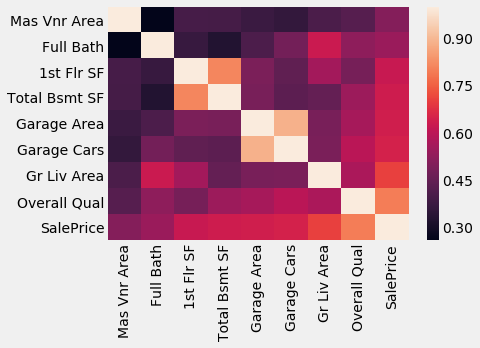

In [27]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

corr_all = data_transformed.corr()
corr_saleprice = corr_all.SalePrice
corr_saleprice = corr_saleprice.abs()

sorted_corrs = corr_saleprice.sort_values()
strong_corrs = sorted_corrs[sorted_corrs > 0.5]
corrmat = data_transformed[strong_corrs.index].corr()
ax = sns.heatmap(corrmat)

We can see that both pairs of features show a very high correlation:
* 'Garage Area' & 'Garage Cars'
* '1st Flr SF': First Floor square feet  & 'Total Bsmt SF': Total square feet of basement area

Since 'Garage Area' is a continuous variable and, therefore, capture more nuance, I decide for dropping 'Garage Cars'. For the other variable it does not really matter which one we choose and I go fo the 'Total Bsmt SF' because it sounds more general. I added this step to the select_features() function

Another step included in the function is the removal of features with low variance - as they don't meaningfully contribute to the model's predictive capability. For this purpose I have rescaled the columns (between 0 and 1) - It is important not to include the target column in this step.

In [28]:
def select_features(data):
    #features deleted based on high correlation
    data.drop(['Garage Cars','1st Flr SF'], axis=1, inplace=True)
    
    #delete features with low variance (all features with variance <  0.01)
    target = 'SalePrice' 
    features = data.columns.tolist()
    features.remove(target)
    x = data[features]
    #re-scaling of features (between 0 and 1)
    unit_data = (x - x.min())/(x.max() - x.min()) 
    s = unit_data.var() > 0.01
    final_features = s[s].index.tolist()    
    
    unit_data = unit_data[final_features]
    #reestablish target to final df
    unit_data[target] = data[target]
    
    return unit_data

In [29]:
data_selected = select_features(data_transformed)
data_selected.head()

,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 2,Bsmt Unf SF,2nd Flr SF,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,TotRms AbvGrd,Fireplaces,Garage Area,SalePrice
0,0.555556,0.500,0.0700,0.000000,0.188784,0.000000,0.333333,0.0,0.25,0.0,0.375,0.384615,0.50,0.354839,215000
1,0.444444,0.625,0.0000,0.094364,0.115582,0.000000,0.000000,0.0,0.25,0.0,0.250,0.230769,0.00,0.490591,105000
2,0.555556,0.625,0.0675,0.000000,0.173801,0.000000,0.000000,0.0,0.25,0.5,0.375,0.307692,0.00,0.209677,172000
3,0.666667,0.500,0.0000,0.000000,0.447346,0.000000,0.333333,0.0,0.50,0.5,0.375,0.461538,0.50,0.350806,244000
4,0.444444,0.500,0.0000,0.000000,0.058647,0.339467,0.000000,0.0,0.50,0.5,0.375,0.307692,0.25,0.323925,189900


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

def train_and_test(data, k=0):
    #select features and target from columns
    target = 'SalePrice' 
    features = data.columns.tolist()
    features.remove(target)
    
    if k == 0:
        #divide dataset in train/test
        train = data.iloc[:1460]
        test = data.iloc[1460:]
    
        #train model
        model = LinearRegression()
        model.fit(data[features],data[target])
    
        #test model on test data
        predictions = model.predict(test[features])
        rmse = mean_squared_error(test[target],predictions) ** (1/2)
        
        return rmse
    
    elif k == 1:
        #REINDEX pandas df indexes
        shuffled_index = np.random.permutation(data.index)
        data = data.reindex(shuffled_index)
        
        #divide dataset in train/test
        fold_one = data.iloc[:1460]
        fold_two = data.iloc[1460:]
        
        #Train on fold_one and test on fold_two.
        model = LinearRegression()
        model.fit(fold_one[features],fold_one[target])
        predictions_1 = model.predict(fold_two[features])
        rmse_1 = mean_squared_error(fold_two[target],predictions_1) ** (1/2)
        
        #Train on fold_two and test on fold_one.
        model = LinearRegression()
        model.fit(fold_two[features],fold_two[target])
        predictions_2 = model.predict(fold_one[features])
        rmse_2 = mean_squared_error(fold_one[target],predictions_2) ** (1/2)
        
        return (rmse_1 + rmse_2) / 2
        
    else:
        # prepare cross validation
        kfold = KFold(k, True, random_state=1)
        
        #train model
        model = LinearRegression()
        model.fit(data[features],data[target])
        
        mses = cross_val_score(model, data[features], data[target], scoring='neg_mean_squared_error', cv=kfold)
        rmses = abs(mses) ** (1/2)
        
        # return average rmse
        return np.mean(rmses) 

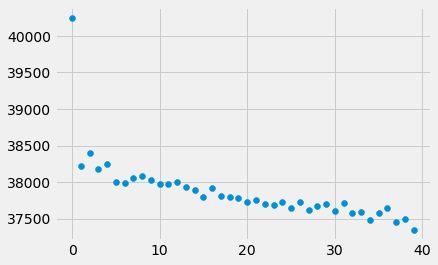

In [31]:
#plot the RMSE for different k values
import matplotlib.pyplot as plt

rmse_list = []
for k_value in range(40):
    rmse_list.append(train_and_test(data_selected,k_value)) 

plt.style.use('fivethirtyeight')
plt.scatter(range(40),rmse_list)    
plt.show()